In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
#rc={'axes.facecolor':'black', 'figure.facecolor':'black'})

In [76]:
data = pd.read_csv('disthistogram', header=0 , delimiter='\t', names=['Harmonic','Arithmetic','Geometric','VeinOrder','NN VeinOrder','v2x','v2y','vx','vy','v2width','vwidth'])
ven = pd.read_csv('venconnections', delimiter='\t')
ven2 = pd.read_csv('ven2connections', delimiter='\t')
im = Image.open('conprofile.png','r')
im2 = Image.open('covgrad.png','r')

In [100]:
im3 = Image.open('coveragesdev3.png','r')

In [77]:
cols = list(data.columns[1:7])
cols += list(data.columns[9:])
countdf = data.groupby(['vx','vy']).agg('count').drop(cols,axis=1).rename(columns={'Harmonic':'count'})
countdf.reset_index(level=0, inplace=True)
countdf.reset_index(level=0, inplace=True)

In [78]:
data = pd.merge(data,countdf,on=['vx','vy'])

In [79]:
cven2 = ven2.copy()
cven2.rename(columns={'startx':'v2x','starty':'v2y'},inplace=True)
cven2 = cven2.groupby(by=['v2x','v2y']).agg('max').drop(['endx','endy'],axis=1)
cven2.reset_index(level=0,inplace=True)
cven2.reset_index(level=0,inplace=True)

In [80]:
cvenend = ven.copy()
cvenend.rename(columns={'endx':'vx','endy':'vy','disttoroot':'disttorootp'},inplace=True)
cvenend = cvenend.groupby(by=['vx','vy']).agg('max').drop(['startx','starty'],axis=1)
cvenend.reset_index(level=0,inplace=True)
cvenend.reset_index(level=0,inplace=True)

In [81]:
cven = ven.copy()
cven.rename(columns={'startx':'vx','starty':'vy','disttoroot':'disttorootp'},inplace=True)
cven = cven.groupby(by=['vx','vy']).agg('max').drop(['endx','endy'],axis=1)
cven.reset_index(level=0,inplace=True)
cven.reset_index(level=0,inplace=True)

In [82]:
cven = pd.concat([cven,cvenend])

In [83]:
data = pd.merge(data,cven2,on=['v2x','v2y'])
data['seglength'] = np.sqrt(np.square(data['v2x']-data['vx'])+np.square(data['v2y']-data['vy']))
#data = pd.merge(data,cven,on=['vx','vy'],how='left')

In [84]:
cvendata = cven.groupby(by=['vx','vy']).agg('max')
cvendata.reset_index(level=0,inplace=True)
cvendata.reset_index(level=0,inplace=True)
cvendata =  pd.merge(data,cvendata,on=['vx','vy'],how='right')

In [85]:
attr = ['disttorootp','vx','vy']

In [86]:
Xtrain = np.array(cvendata[attr][pd.notna(cvendata['count'])]).reshape(-1,len(attr))
Xtest = np.array(cvendata[attr][pd.isna(cvendata['count'])]).reshape(-1,len(attr))
ytrain = np.array(cvendata[['count']][pd.notna(cvendata['count'])]).reshape(-1,1)
ytest = np.array(cvendata[['count']][pd.isna(cvendata['count'])]).reshape(-1,1)

In [87]:
tree = DecisionTreeClassifier(max_depth=3)
tree = tree.fit(Xtrain,ytrain)
cvendata['count'][pd.isna(cvendata['count']) ] = tree.predict(Xtest)

In [88]:
Xtrain = np.array(cvendata[attr][pd.notna(cvendata['vwidth'])]).reshape(-1,len(attr))
Xtest = np.array(cvendata[attr][pd.isna(cvendata['vwidth'])]).reshape(-1,len(attr))
ytrain = np.array(cvendata['vwidth'][pd.notna(cvendata['vwidth'])]).reshape(-1,1)
ytest = np.array(cvendata['vwidth'][pd.isna(cvendata['vwidth'])]).reshape(-1,1)

In [89]:
tree = DecisionTreeRegressor(max_depth=3)
tree = tree.fit(Xtrain,ytrain)
cvendata['vwidth'][pd.isna(cvendata['vwidth']) ] = tree.predict(Xtest)

In [90]:
ven2std = ven2.iloc[:,4].std()
ven2max = ven2.iloc[:,4].max()
ven2min = ven2.iloc[:,4].min()
venstd = ven.iloc[:,4].std()
venmax = ven.iloc[:,4].max()
venmin = ven.iloc[:,4].min()
#normcm = (ven2max - ven2['disttoroot'])/(ven2max-ven2min)

In [91]:
copyven2_1 = ven2.copy()
copyven2_2 = ven2.copy()
copyven2_2.rename(columns={'endx':'v2x','endy':'v2y'},inplace=True)
copyven2 = pd.merge(copyven2_2,data,on=['v2x','v2y'],how='inner')


In [92]:
disc = list(data['disttoroot'].quantile(np.linspace(0,1,4)))
data['dtrootclass']=0
for i in range(0,len(disc)-1):
    data['dtrootclass'].loc[(data['disttoroot']>disc[i]) &  (data['disttoroot']<disc[i+1])] = float(i)+1.0

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Gerando um grafo a partir dos nodos das venações. Preciso encontrar uma representação que explique os dados que encontrei no outro notebook (picos que aparecem na derivada temporal da cobertura). Figura mostrada abaixo.

In [95]:
Xtrain = np.array(data[['v2x','v2y']]).reshape(-1,2)
ytrain = np.array(data[['dtrootclass']]).reshape(-1)
lst = []
for i, j in enumerate(cvendata[['vx','vy']].groupby(['vx','vy']).agg('count').index):
    lst += [list(j)]
primary = np.array(lst).reshape(-1,2)
primarylabels = np.ones(primary.shape[0])*4
Xtrain = np.concatenate([Xtrain,primary])
ytrain = np.concatenate([ytrain,primarylabels])
knnclassifier = KNeighborsClassifier(n_neighbors=1).fit(Xtrain,ytrain)

<Figure size 864x864 with 0 Axes>

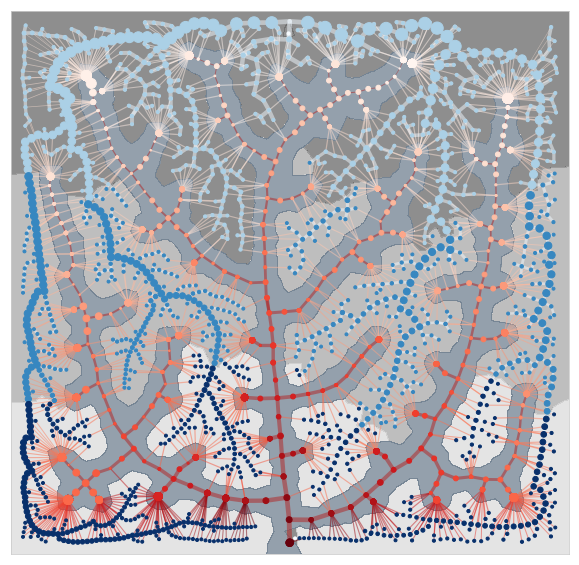

In [98]:
fig = plt.figure(figsize=(12,12))
cmapseg = plt.cm.get_cmap('Reds')
rgba = cmapseg(np.square(data['disttoroot'])/(np.square(data['disttoroot']).max()-np.square(data['disttoroot']).min()))
fig = plt.figure(figsize=(10,10))

X_set, y_set = Xtrain, ytrain
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
z = knnclassifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
plt.contourf(X1, X2, z, zorder=1,
             alpha = 0.75, cmap = ListedColormap(('dimgray','dimgray', 'darkgrey','gainsboro','slategrey')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i in range(data.shape[0]):
    plt.plot(data.iloc[i][5:9:2],data.iloc[i][6:9:2],'-',color=rgba[i],linewidth=np.power((data['seglength'].max()-data.iloc[i]['seglength'])/(data['seglength'].std()),0.3)-0.5,alpha=0.5,zorder=2)
for i in range(ven.shape[0]):
    plt.plot(ven.iloc[i][0:4:2],ven.iloc[i][1:4:2],'-',c='firebrick',markersize=1,linewidth=(venmax-ven.iloc[i][4])/venstd+0.5,alpha=0.5,zorder=2)
for i in range(copyven2.shape[0]):
    plt.plot(copyven2.iloc[i][0:4:2],copyven2.iloc[i][1:4:2],'-',c='aliceblue',linewidth=(ven2max - copyven2.iloc[i][4])/ven2std + 0.5,alpha=0.5,zorder=2)

plt.scatter(data['v2x'],data['v2y'],s=np.power(10*np.array(data['v2width'])+3,1.79),c=data['dtrootclass'], cmap=plt.get_cmap('Blues'),zorder=3)
plt.scatter(cvendata['vx'],cvendata['vy'],s=cvendata['count']+np.power(2*np.array(cvendata['vwidth']),2.82),c=(cvendata['disttorootp'].max()-cvendata['disttorootp'])/cvendata['disttorootp'].std(), cmap=plt.get_cmap('Reds'),zorder=3)
plt.xticks([])
plt.yticks([])
plt.show()
fig.savefig(fname = "centeredvenation.png", dpi = 150)

A rede apresentada acima facilita a compreensão do comportamento observado na figura abaixo, com 3 picos para cada uma das curvas. Cada pico representa um "burst" de cobertura de corante, ou seja, representa um aumento significativo na taxa cobertura de corante. Cada burst está associado a regiões da árvore complementar que tem graus de facilidade distintos em transportar o corante para a saída. Os nodos da rede complementar acima estão representados em 3 tons de azul distintos e cada um pode ser associado a um pico abaixo. A região associada aos nodos em azul claro (em cinza escuro) é a primeira a receber uma quantidade significativa de corante ao ponto aumentar a concentração da região. Isso pode ser conferido no perfil de concentração obtido a partir da simulação de CFD mostrado ainda mais abaixo. Observe que as regiões mais claras na outra figura, onde o corante já está mais presente, correspondem a esta região do grafo. O primeiro pico do gráfico da derivada da cobertura significa que quando o corante atinge essa região há um rápido aumento da concentração nos canais complementares da região. Esses canais complementares acabam servindo como fonte para mais difusão ocorrer em outras regiões mais acima próximo ao outlet. No caso dos modelos primarios centrados, em que o inlet está conectado a venação primária, dividimos a venação complementar em três, como fica evidente pela figura, sendo que cada região estaria associada a um dos picos que observamos na figura mais abaixo. Nos modelos em que invertemos a posição do inlet e outlet, também os observamos 3 picos, mas o último é apenas um ombro distante que precede um rápido decaimento para zero. No caso dos modelos diagonais complementares o 3 pico não fica evidente, ainda assim consideramos a divisão em 3 regiões.

Essa divisão em 3 regiões e possivelmente as áreas associadas a cada uma delas sejam bons atributos preditores de performance (cobertura), pois, de acordo com nossa interpretação, estão associados aos picos. Assim, computamos e armazenamos essas áreas para cada um dos modelos.

In [99]:
X2range = X2.max()-X2.min()
pointarea = (X2range/X2.shape[0])*(X2range/X2.shape[1])
totalarea = np.square(X2range)
areaperregion = []
areaproportionperclass = []
for i in range(0,5):
    areaperregion += [(i,np.array(z==i).sum()*pointarea)]
    areaproportionperclass += [(i,np.array(z==i).sum()*pointarea/totalarea)]
print('area per region: ', areaperregion,'\narea proportion per class: ',areaproportionperclass)

area per region:  [(0, 1.6327523099850996), (1, 579.2991398765179), (2, 494.4203145837777), (3, 428.3261891420063), (4, 701.5632040877167)] 
area proportion per class:  [(0, 0.0007403961135075163), (1, 0.2626919154239231), (2, 0.2242023343763227), (3, 0.19423095825056336), (4, 0.31813439583568326)]


A curva em vermelho representa os modelos primários centrados, em azul temos os primários diagonais, a curva laranja representa os modelos centrados complementares e por fim a curva em verde representa os modelos diagonais complementares. Os primeiros 2 picos na curva azul e vermelho estão muito proximos para este threshold (há sobreposição, mas para outros mais baixos a separação fica mais evidente). O terceiro pico fica claramente destacado para estas curvas (na curva vermelho parece mais um ombro). Os dois primeiros picos para os modelos complementares estão evidentes para esta escolha de threshold. A região 'constante' com um ombro no final pode ser associada a terceira região para estas geometrias. Por fim a curva verde não tem um 3 pico evidente. Há uma variação natural para todas estas curvas, algo que acredito estar intrinsicamente com a geometria e suas ramificações. 

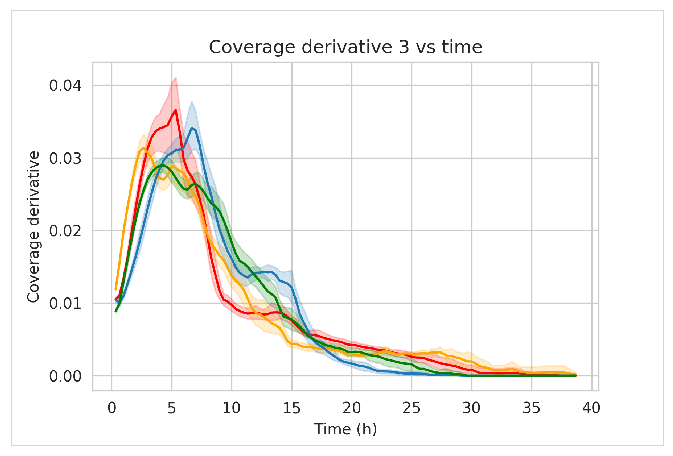

In [107]:
fig = plt.figure(figsize=(15,8))
plt.imshow(np.asarray(im3))
plt.xticks([])
plt.yticks([])
plt.show()

O grafo acima precisa de alguma forma representar o que vemos abaixo, o resultado da simulação.

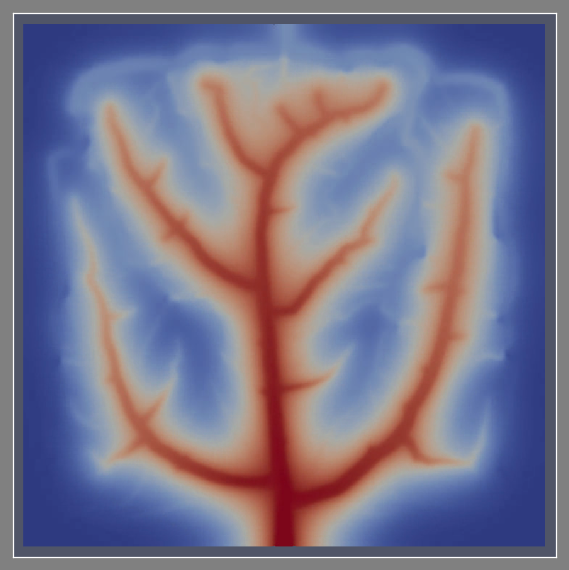

In [1055]:
fig = plt.figure(figsize=(10,10))
plt.imshow(np.asarray(im))
plt.xticks([])
plt.yticks([])
plt.show()

Os picos que vemos abaixo são "bursts" no qual há um aumento grande na cobertura do corante. Provavelmente tem a ver com os nodos mais importantes da venação.

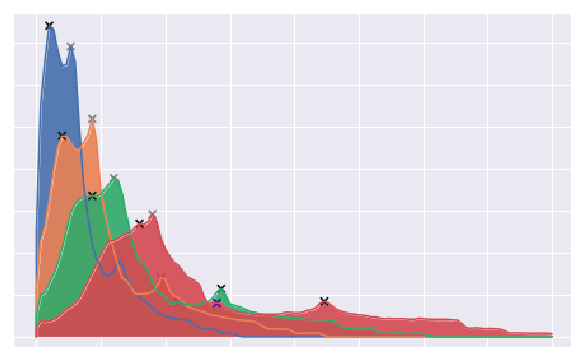

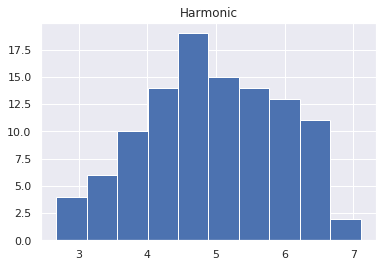

In [14]:
data.groupby(['VeinOrder','NN VeinOrder']).get_group((2,3)).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1).hist(bins=10)
#plt.xlim(1,6)
plt.show()
#data['NN VeinOrder'].hist(bins=10)
#plt.xlim(1,5)
#plt.show()

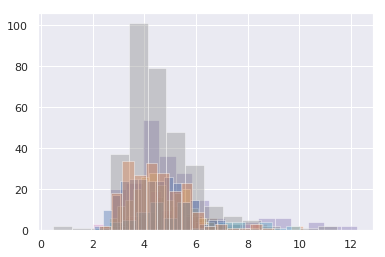

In [19]:
for i in range(1,5):
    for j in range(1,4):
        df = data.groupby(['VeinOrder','NN VeinOrder']).get_group((i,j)).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1)
        sns.distplot(df, bins=15,hist=True, kde=False, rug=False)

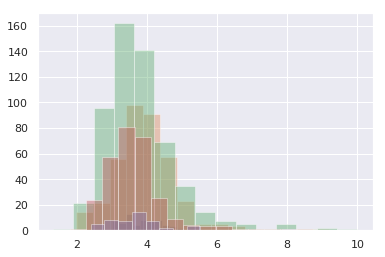

In [100]:
for i in range(1,6):
    df = data.groupby('VeinOrder').get_group(i).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1)
    sns.distplot(df, bins=15,hist=True, kde=False, rug=False)



In [53]:
data.describe()

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder
count,1339.000000,1339.000000,1339.000000,1339.000000,1339.00000
mean,3.814889,4.091761,3.949626,2.908887,2.45183
std,0.950355,0.956059,0.949267,0.920163,0.77693
min,1.324530,1.804050,1.637970,1.000000,1.00000
25%,3.195470,3.515505,3.372795,2.000000,2.00000
50%,3.683680,3.983070,3.827150,3.000000,2.00000
75%,4.198680,4.506980,4.352100,3.500000,3.00000
max,9.997340,9.997340,9.997340,6.000000,4.00000


In [49]:
data.head()

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder
0,4.67798,4.72853,4.70258,2,2
1,4.64436,4.64436,4.64436,1,3
2,2.68025,3.43605,3.09173,2,2
3,4.92177,4.94629,4.93402,1,3
4,3.91793,4.11680,4.01123,3,2


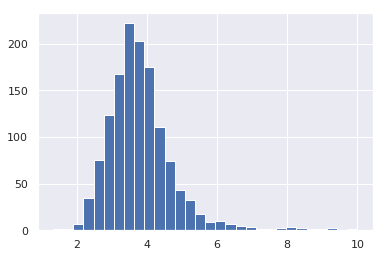

In [91]:
data['Harmonic'].hist(bins=30)
plt.show()


In [22]:
data.mean()

Distances Histogram    3.814889
dtype: float64

In [23]:
data.describe()

,Distances Histogram
count,1339.000000
mean,3.814889
std,0.950355
min,1.324530
25%,3.195470
50%,3.683680
75%,4.198680
max,9.997340


In [24]:
data.median()

Distances Histogram    3.68368
dtype: float64

In [28]:
data.kurtosis()

Distances Histogram    6.198549
dtype: float64

In [29]:
data.skew()

Distances Histogram    1.737346
dtype: float64